# Parametric Compilation Examples

In this notebook, we demonstrate parametric compilation by way of three "experiments": 

* Qubit Spectroscopy, in which we sweep over a detuning parameter,
* Power Rabi, in which we sweep over pulse scale,
* Time Rabi, in which we sweep over pulse duration.

The intent here is to demonstrate Quil-T features; as such we do not do much in the way of data analysis.

In [1]:
from typing import Optional
from pyquil import Program, get_qc
from pyquil.quilatom import Qubit, Frame
from pyquil.quilbase import Gate, Pulse, DefCalibration
from pyquil.gates import RX

qc = get_qc('Aspen-8')

In [2]:
cals = qc.compiler.calibration_program

First, we write a useful little helper, to extract the first pulse from a gate calibration.

In [3]:
import numpy as np

def get_pulse(cal: DefCalibration) -> Optional[Pulse]:
    return next((i for i in cal.instrs if isinstance(i, Pulse)), None)

rx0 = cals.get_calibration(RX(np.pi, 0))
print(get_pulse(rx0))

NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 1.2e-07, fwhm: 3e-08, t0: 6e-08, anh: -190000000.0, alpha: -0.5128791143256078, scale: 0.63376686965814, phase: 0.0, detuning: 0.0)


## Qubit Spectroscopy


Here we present a simple Qubit spectroscopy experiment. The general idea is that we scan over a range of frequencies, applying a pulse and measuring the resulting probability that the qubit is excited. There are some natural matters which we do _not_ concern ourselves with, for example the choice of pulse duration, or carefully inspecting the readout values. Instead we wish to demonstrate how this sort of experiment can be done using parametric compilation.

We first define a function which can produce a parametric program to perform this experiment.

In [4]:
def qubit_spectroscopy(qubit: int, param: str, *, calibrations: Program, shots: int = 1000) -> Program:
    """ Generate a program for doing a Qubit spectroscopy experiment.
    
    :param qubit: The qubit index to run on.
    :param param: The name of the parameter used for detuning.
    :param calibrations: The QPU calibrations, needed in order to identify an appropriate pulse and frame.
    :param shots: The number of shots to execute for a single run.
    """
    
    # The basic idea is:
    # - shift the frequency by the amount indicated by `param`
    # - do an RX(pi) gate
    # - measure
    
    # We first find the frame on which the RX(pi) pulse is applied.
    cal = calibrations.get_calibration(RX(np.pi, qubit))
    pulse = get_pulse(cal)
    frame = pulse.frame
    
    # When we construct the program, we are sure to include the frame definition
    # (since SHIFT-FREQUENCY is applied to this frame).
    return Program(
        calibrations.frames[pulse.frame],
        'DECLARE ro BIT',
        f'DECLARE {param} REAL',
        f'SHIFT-FREQUENCY {frame} {param}',
        f'RX(pi) {qubit}',
        f'MEASURE {qubit} ro'
    ).wrap_in_numshots_loop(1000)

print(qubit_spectroscopy(0, 'detuning', calibrations=cals))

DEFFRAME 0 "rf":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 5145219610.47124
    CENTER-FREQUENCY: 5250000000.0
    HARDWARE-OBJECT: "q0_rf"
    SAMPLE-RATE: 1000000000.0

DECLARE ro BIT[1]
DECLARE detuning REAL[1]
SHIFT-FREQUENCY 0 "rf" detuning[0]
RX(pi) 0
MEASURE 0 ro[0]



Now we compile and run, considering detuning frequencies in the range from -3 MHz to +3 MHz. Note that with parametric compilation we only require one call to the compiler.

In [5]:
exe = qc.compiler.native_quil_to_executable(qubit_spectroscopy(0, 'detuning', calibrations=cals))

detunings = np.linspace(-3e6, 3e6, 100)
dprobs = []
for detuning in detunings:
    exe.write_memory(region_name='detuning', value=detuning)
    results = qc.run(exe)
    p1 = np.sum(results)/len(results)
    dprobs.append(p1)

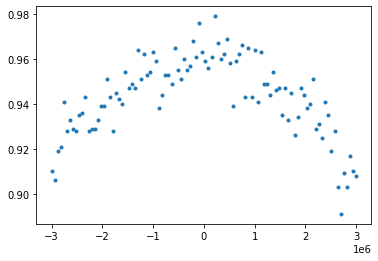

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(detunings, dprobs, '.')

## Power Rabi

We consider another experiment, in which we vary the waveform amplitude and consider how this effects the probability that a qubit is excited. This is formally quite similar to the previous Qubit spectroscopy.

In [7]:
from copy import deepcopy

def power_rabi(qubit: int, param: str, *, calibrations: Program, shots: int = 1000) -> Program:
    """ Generate a program for doing a power Rabi experiment.
    
    :param qubit: The qubit index to run on.
    :param param: The name of the parameter used for amplitude scaling.
    :param calibrations: The QPU calibrations, needed in order to identify an appropriate pulse and frame.
    :param shots: The number of shots to execute for a single run.
    """
    
    # The basic idea is:
    # - set the frame scaling to the amount indicated by `param`
    # - perform the pulse of an RX(pi) gate
    # - measure
    
    # We first find the frame on which the RX(pi) pulse is applied.
    cal = calibrations.get_calibration(RX(np.pi, qubit))
    pulse = get_pulse(cal)
    frame = pulse.frame
    
    # When we construct the program, we are sure to include the frame definition
    # (since SET-SCALE is applied to this frame).
    return Program(
        calibrations.frames[pulse.frame],
        'DECLARE ro BIT',
        f'DECLARE {param} REAL',
        f'SET-SCALE {frame} {param}',
        f'RX(pi) {qubit}',
        f'MEASURE {qubit} ro'
    ).wrap_in_numshots_loop(1000)

print(power_rabi(0, 'scale', calibrations=cals))

DEFFRAME 0 "rf":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 5145219610.47124
    CENTER-FREQUENCY: 5250000000.0
    HARDWARE-OBJECT: "q0_rf"
    SAMPLE-RATE: 1000000000.0

DECLARE ro BIT[1]
DECLARE scale REAL[1]
SET-SCALE 0 "rf" scale[0]
RX(pi) 0
MEASURE 0 ro[0]



In [8]:
exe = qc.compiler.native_quil_to_executable(power_rabi(0, 'scale', calibrations=cals))

scales = np.linspace(1e-4, 1.0, 20)
sprobs = []
for scale in scales:
    exe.write_memory(region_name='scale', value=scale)
    results = qc.run(exe)
    p1 = np.sum(results)/len(results)
    sprobs.append(p1)

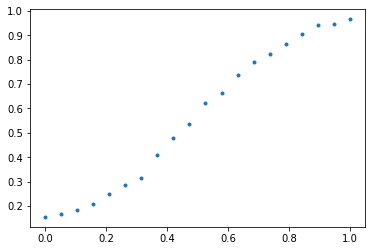

In [9]:
%matplotlib inline

plt.plot(scales, sprobs, '.')

## Time Rabi

Key to our use of parametric compilation in the previous two experiments is that the variable which we were speeping over (frequency or scale) had an associated Quil-T instruction (`SHIFT-FREQUENCY` or `SET-SCALE`). In this example we consider a "Time Rabi" experiment, which involves varying the pulse length. 

A current limitation of Quil-T is that waveforms must be resolved at compile time, and so the `duration` field of a template waveform cannot be a run-time parameter. The workaround for our Time Rabi experiment is that we must generate a new program for each value of `duration`, and we cannot rely on parametric compilation for this.

In [10]:
from copy import deepcopy

def time_rabi(qubit: int, duration: float, *, calibrations: Program, shots: int = 1000) -> Program:
    """ Generate a program for doing a time Rabi experiment.
    
    :param qubit: The qubit index to run on.
    :param duration: The pulse duration, in seconds.
    :param calibrations: The QPU calibrations, needed in order to identify an appropriate pulse and frame.
    :param shots: The number of shots to execute for a single run.
    """
    
    # The basic idea is:
    # - get the pulse associated to an RX(pi) gate
    # - perform a modified version of this, with the `duration` updated
    # - measure
    
    # We first find the frame on which the RX(pi) pulse is applied.
    cal = calibrations.get_calibration(RX(np.pi, qubit))
    pulse = get_pulse(cal)
    frame = pulse.frame
    fdefn = calibrations.frames[frame]
    
    updated_pulse = deepcopy(pulse)
    # Note: duration must be aligned to 4 sample boundaries.
    updated_pulse.waveform.duration = 4*np.round(duration*fdefn.sample_rate / 4) / fdefn.sample_rate
    
    # When we construct the program, we are sure to include the frame definition
    # (since SET-SCALE is applied to this frame).
    return Program(
        fdefn,
        'DECLARE ro BIT',
        updated_pulse,
        f'MEASURE {qubit} ro'
    ).wrap_in_numshots_loop(1000)

print(time_rabi(0, 1e-8, calibrations=cals))

DEFFRAME 0 "rf":
    DIRECTION: "tx"
    INITIAL-FREQUENCY: 5145219610.47124
    CENTER-FREQUENCY: 5250000000.0
    HARDWARE-OBJECT: "q0_rf"
    SAMPLE-RATE: 1000000000.0

DECLARE ro BIT[1]
NONBLOCKING PULSE 0 "rf" drag_gaussian(duration: 8e-09, fwhm: 3e-08, t0: 6e-08, anh: -190000000.0, alpha: -0.5128791143256078, scale: 0.63376686965814, phase: 0.0, detuning: 0.0)
MEASURE 0 ro[0]



In [11]:
times = np.linspace(1e-9, 100e-9, 20)
tprobs = []
for time in times:
    exe = qc.compiler.native_quil_to_executable(time_rabi(0, time, calibrations=cals))
    results = qc.run(exe)
    p1 = np.sum(results)/len(results)
    tprobs.append(p1)

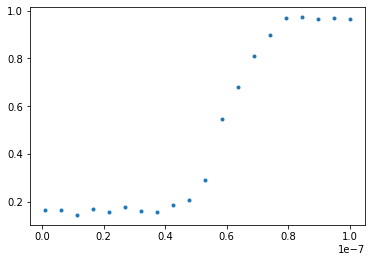

In [12]:
%matplotlib inline

plt.plot(times, tprobs, '.')